# Exercise 4

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

## Task 1
(3 points)

Implement the training loop for one training epoch.
An epoch trains on the whole training dataset once.

In [2]:
def train(model, use_cuda, train_loader, optimizer, epoch, log_interval):
    """
    Train one epoch
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    train_loader -- data loader
    optimizer -- network optimizer
    epoch -- number of current epoch
    log_interval -- number of training steps between logs
    """
    # TODO: set the model to train mode
    model.train()
    running_loss = 0
    
    # TODO: enumerate over the dataloader to get mini batches
    #       of images and ground truth labels
    # HINT: the builtin python function enumerate() also gives you indices
    for batch_idx, (data, target) in enumerate(train_loader):
        # for each batch
        if use_cuda:
            # transfer to GPU
            data = data.cuda()
            target = target.cuda()
    
        # TODO: set the optimizers gradients to zero
        optimizer.zero_grad()
        
        # TODO: run the network
        output = model(data)
        
        # TODO: compute negative log likelihood loss
        train_loss = F.nll_loss(output, target, reduction='sum')
        
        # TODO: do backpropagation
        train_loss.backward()
        
        # TODO: optimize
        optimizer.step()
        
        # TODO: print current loss for every nth ("log_interval"th) iteration
        running_loss += train_loss.item()
        if batch_idx % log_interval == log_interval-1:
            print('[epoch: %d, batch_idx: %5d] loss: %.3f' %
                  (epoch, batch_idx + 1, running_loss / log_interval))
            running_loss = 0.0   

We already implemented the validation function for you (this is essentially validate() from the last exercise)

In [3]:
def validate(model, use_cuda, test_loader):
    """
    Compute test metrics
    
    model -- the neural network
    use_cuda -- true if GPU should be used
    test_loader -- data loader
    """
    # create a 10x10 grid of subplots
    _, axis = plt.subplots(10, 10)
    
    # set model to evaluation mode
    model.eval()
    test_loss = 0
    correct = 0
    plotted = 0
    
    # disable gradients globally
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            # for each batch
            if use_cuda:
                # transfer to GPU
                data = data.cuda()
                target = target.cuda()
            
            # run network and compute metrics
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            
            img_correct = pred.eq(target.view_as(pred))
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # plot the first 100 images
            img_idx = 0
            data = data.cpu().numpy()
            
            while plotted < 100 and img_idx < data.shape[0]:
                # compute position of ith image in the grid
                y = plotted % 10
                x = plotted // 10
                
                # convert image tensor to numpy array and normalize to [0, 1]
                img = data[img_idx, 0]
                img = (img - np.min(img)) / (np.max(img) - np.min(img))
                
                # make wrongly predicted images red
                img = np.stack([img] * 3, 2)
                if img_correct[img_idx] == 0:
                    img[:, :, 1:] = 0.0
                
                # disable axis and show image
                axis[y][x].axis('off')
                axis[y][x].imshow(img)
                
                # show the predicted class next to each image
                axis[y][x].text(30, 25, pred[img_idx].item())
                
                plotted += 1
                img_idx += 1
            
    test_loss /= len(test_loader.dataset)

    # show results
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    plt.show()

## Task 2
(4 points)

Implement a five-layer fully connected neural network.
The dimensions (without batch size) should change like this: 784->200->100->60->30->10
Use log softmax to compute the class predictions.

Run the code at the end of the notebook to train and validate your implementation.

### Task 2.1
* sigmoid non-linear activation function
* note that the last layer does not need an activation function!

### Task 2.2
* add a new class "FCNet2"
* replace sigmoid with ReLU

### Task 2.3
* add a new class "FCNet2"
* add batch normalization to the first and third layers (note the difference between 1D/2D/3D versions)


**NOTE:** The perfomance should improve slightly with each step. However, due to the random weight initialization applied by PyTorch, your results may vary a bit between trainings.

In [4]:
class FCNet1(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with sigmoid non-linearity
    
    Dimensions
    28x28 = 784
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet1, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # TODO: run network layers
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [5]:
class FCNet2(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with relu (linearity)
    
    Dimensions
    28x28 = 784
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet2, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784,200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # TODO: run network layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

In [6]:
class FCNet3(nn.Module):
    """
    Fully Connected Neural Network
    
    Five fully connected layers with relu (linearity)
    
    Batch normalization of the first and third layers
    
    Dimensions
    28x28 = 784
    784->200->100->60->30->10
    """
    def __init__(self):
        super(FCNet3, self).__init__()
        
        # TODO: initialize network layers
        # HINT: take a look at "torch.nn" (imported as "nn")
        self.fc1 = nn.Linear(784,200)
        self.fc1_bn = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200,100)
        self.fc3 = nn.Linear(100,60)
        self.fc3_bn = nn.BatchNorm1d(60)
        self.fc4 = nn.Linear(60,30)
        self.fc5 = nn.Linear(30,10)
       

    def forward(self, x):
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 784)
        
        # TODO: run network layers
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3_bn(self.fc3(x)))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        
        # TODO: compute log softmax over the output
        # HINT: take a look at "torch.nn.functional" (imported as "F")
        output = F.log_softmax(x, dim=1)
        
        return output

## Task 3
(3 points)

Implement a convolutional neural network, consisting of two convolutional and two fully connected layers.
This time, the dimensions (without batch size) should change like this: 1x28x28->32x26x26->64x12x12->128->10

### Task 3.1
* two convolutional layers (kernel size 3)
* two fully-connected layers
* ReLU activation function

### Task 3.2
* add batch normalization to first convolutional and first fully connected layer

### Task 3.3
* use max pooling instead of stride to reduce the dimensions to 64x12x12

In [7]:
class ConvNet1(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet1, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
    
        # TODO: run convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [8]:
class ConvNet2(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers and two fully connected layers
    
    Batch normalization of first convolutional and first fully connected layer
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet2, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
    
        # TODO: run convolutional layers
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = F.relu(self.conv2(x))
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

In [9]:
class ConvNet3(nn.Module):
    """
    Convolutional Neural Network
    
    Two convolutional layers, one pooling layer and two fully connected layers
    
    Batch normalization of first convolutional and first fully connected layer
    
    Dimensions:
    1x28x28->32x26x26->64x12x12->128->10
    """
    def __init__(self):
        super(ConvNet3, self).__init__()
        
        # TODO: initialize network layers
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv1_bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(3, 2, padding=1)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
    
        # TODO: run convolutional layers
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # TODO: reshape batch of images to batch of 1D vectors
        x = x.view(-1, 64 * 12 * 12)
        
        # TODO: run fully connected layers
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = self.fc2(x)
        
        # TODO: compute log softmax over the output
        output = F.log_softmax(x, dim=1)
        
        return output

[epoch: 1, batch_idx:   100] loss: 17.181
[epoch: 1, batch_idx:   200] loss: 5.922
[epoch: 1, batch_idx:   300] loss: 4.481
[epoch: 1, batch_idx:   400] loss: 4.157
[epoch: 1, batch_idx:   500] loss: 3.372
[epoch: 1, batch_idx:   600] loss: 3.735
[epoch: 1, batch_idx:   700] loss: 2.948
[epoch: 1, batch_idx:   800] loss: 3.808
[epoch: 1, batch_idx:   900] loss: 2.526

Test set: Average loss: 0.0349, Accuracy: 9888/10000 (98.88%)



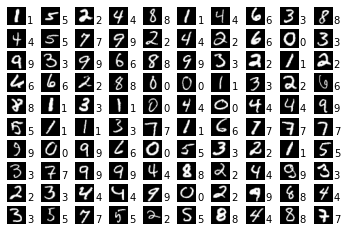

In [15]:
# hyper parameters
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 1.0
gamma = 0.7
log_interval = 100

# use GPU if available
use_cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# initialize data loaders
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, 
    transform=transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

model = ConvNet3()
if use_cuda:
    model = model.cuda()

# initialize optimizer and scheduler
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(1, epochs + 1):
    # train one epoch
    train(model, use_cuda, train_loader, optimizer, epoch, log_interval)
    
    # run on test dataset
    validate(model, use_cuda, test_loader)
    scheduler.step()
    
    
    torch.save(model.state_dict(), "models/mnist/checkpoint.pt")